In [1]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand

In [2]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
from torch.nn.init import kaiming_uniform_
seed(1)

In [3]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size

In [4]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done'))
Xp_points = Xp(5,6,7,8,9)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9)

In [5]:
def extract_tensors(experiences):
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    return state,action,next_state,reward,done

In [6]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start = -2,
                   log_base=10
):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    
    values = np.logspace(log_start,
                        0,
                        decay_steps,
                        base = log_base,
                        endpoint = True)[::-1]

    
    values = (values - values.min())/(values.max() - values.min())
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [7]:
class linearApproximator(nn.Module):
    def __init__(self,state_shape,n_fc1,n_fc2, action_n):
        super(linearApproximator, self).__init__()
        self.input_size = state_shape
        self.n_fc1 = n_fc1
        self.n_fc2 = n_fc2
        self.out = action_n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,self.n_fc1)
        self.fc2  = nn.Linear(self.n_fc1,self.n_fc2)
        self.fc3  = nn.Linear(self.n_fc2,self.out)
        self.to(self.device)
        
    def forward(self, state_shape):
        x = self.fc1(state_shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)
        return out

In [8]:
#update target model after n timesteps
def update_target_network(target_network, online_network):
    target_network.load_state_dict(online_network.state_dict())

In [9]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [10]:
env = gym.make("CartPole-v0")

In [11]:
def select_action(state, model, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float()
    with torch.no_grad():
        q_values= model(state).cpu().detach()
        q_values = q_values.data.numpy().squeeze()
    if np.random.rand() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

In [12]:
#sample batches before model update
def update_online_model(experience_samples, online_model, target_model, gamma, optimizer):
    state, action, next_state, reward, done = extract_tensors(experience_samples) 
    #print("ns shape: ",next_state.shape)
    next_state = torch.tensor(next_state).float()
    reward = torch.tensor(reward).float()
    action = torch.tensor(action)
    action = action.type(torch.LongTensor)
    state = torch.tensor(state).float()
    done = torch.tensor(done).float()
    #print("ns_t shape: ",next_state.shape)
    q_next_states = target_model(next_state)
    q_next_states = q_next_states.detach()
    
    #print()
    
    q_next_states_max = q_next_states.max(1)[0].unsqueeze(1)#select the values
    done = done.unsqueeze(1)
    #q_next_states_max
    #print(done, "shape_d: ",done.shape)
    #print(q_next_states_max, "shape: ",q_next_states_max.shape)
    q_next_states_max *= (1 - done)
    
    
    q_target = reward + gamma*q_next_states_max
    q_states = online_model(state)
    #print("shape: ", action.shape, "arr: ", action)
    action = action.unsqueeze(1)
    q_states = q_states.gather(1, action)#select actions
    q_error = q_target - q_states
    q_loss = q_error.pow(2).mul(0.5).mean()
    
    optimizer.zero_grad()
    q_loss.backward()
    optimizer.step()

In [13]:
def epsilon_decay_linear(init_eps, min_eps, decay_ratio, timestep, timestep_max):
    #timestep_max = (timestep + 1)*100000
    decay_t_step = timestep_max*decay_ratio
    epsilon = 1 - timestep/decay_t_step
    epsilon *= init_eps-min_eps
    epsilon+=min_eps
    epsilon = np.clip(epsilon, min_eps, init_eps)
    return epsilon

In [14]:
e_arr = []
#higher epsilon, slower decay
for e in tqdm(range(100000)):
    eps_ = epsilon_decay_linear(1.0, 0.01, 0.6, e, 100000)
    e_arr.append(eps_)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 68801.76it/s]


In [15]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(e_arr):
    y.append(i)
    x.append(e)

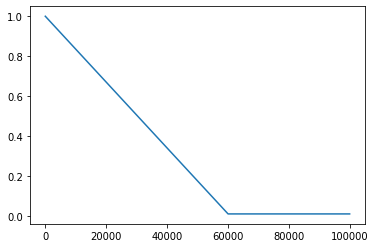

In [16]:
plt.plot(y, x)

In [17]:
def DQN_(env,
         gamma=0.8,
         memory_size = 50000,
         init_epsilon=1.0,
         min_epsilon=0.3,
         epsilon_decay_ratio=0.6,
         sample_size=64,
         n_ep=20000,
        target_update=15,
        max_t_steps = 100000):
    
    action_space = env.action_space.n
    state = env.reset()
    
    online_net = linearApproximator(len(state), 512, 128, action_space)
    target_net = linearApproximator(len(state), 512, 128, action_space)
    
    target_net.load_state_dict(online_net.state_dict())
    target_net.eval()
    freeze_model(target_net)
    optimizer = torch.optim.Adam(online_net.parameters(),lr=0.0005)
    
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        curr_reward = 0
        while True:
            epsilon = epsilon_decay_linear(init_epsilon, min_epsilon, epsilon_decay_ratio, t_step, max_t_steps)
            action = select_action(state, online_net, epsilon)
            next_state, reward, done, info = env.step(action)
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            done = is_failure
            curr_reward+=reward
            
            memory.push(Xp(state,action,next_state,reward,done))
            
            t_step+=1
            
            state = next_state
            if memory.can_provide_sample(sample_size):
                experience_samples = memory.sample(sample_size)
                update_online_model(experience_samples, online_net, target_net, gamma, optimizer)
                
            if t_step % target_update == 0:
                update_target_network(target_net, online_net)
                #print(t_step)
            if done == True:
                break    
        reward_per_ep.append(curr_reward)
        if t_step >= max_t_steps:
            break
    return reward_per_ep

In [18]:
rewards = DQN_(env)

 14%|██████████▌                                                                  | 2749/20000 [05:59<37:35,  7.65it/s]


In [19]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(rewards):
    y.append(i)
    x.append(e)

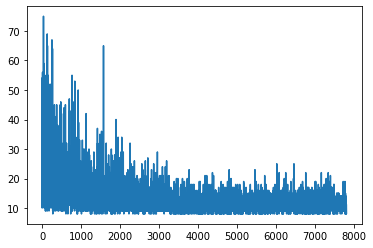

In [68]:
plt.plot(y, x)

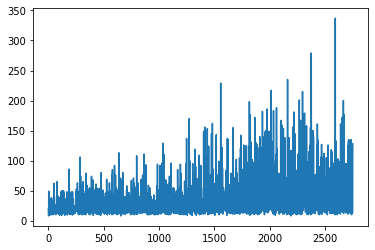

In [20]:
plt.plot(y, x)

In [402]:
def nfq_(env,
         gamma=0.99,
         init_alpha=0.5,
         min_alpha=0.01,
         alpha_decay_ratio=0.5,
         init_epsilon=1.0,
         min_epsilon=0.1,
         epsilon_decay_ratio=0.5,
         k=40,
         sample_size=100,
         n_ep=3000):
    
    epsilons = decay_schedule(
    init_epsilon,
    min_epsilon,
    epsilon_decay_ratio,
    n_ep)
    
    action_space = env.action_space.n
    state = env.reset()
    state_space = np.zeros((len(state)))
    
    model = linearApproximator(len(state), 100, action_space)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
    
    experience = []
    reward_per_ep = []
    for e in tqdm(range(n_ep)):
        state = env.reset()
        curr_reward = 0
        while True:
            action = select_action(state, model, epsilons[e])
            next_state, reward, done, info = env.step(action)
            curr_reward+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            done = is_failure
            exp_tuple = (state, action, next_state, reward, done)
            experience.append(exp_tuple)
            if len(experience) == sample_size:
                for index in range(k):
                    t_next_states = [ns for s, a, ns, r, d in experience]
                    t_rewards = [r for s, a, ns, r, d in experience]
                    t_states = [s for s, a, ns, r, d in experience]
                    t_done = [d for s, a, ns, r, d in experience]
                    t_actions = [a for s, a, ns, r, d in experience]
                
                    t_next_states = torch.tensor(t_next_states).float()
                    t_states = torch.tensor(t_states).float()
                    t_actions = torch.tensor(t_actions)#shoulb be int or long
                    t_rewards = torch.tensor(t_rewards).float()
                    t_done = torch.tensor(t_done).float()
                    
                    optimizer.zero_grad()
                    next_states_action_pairs = model(t_next_states).detach()
                    next_states_action_pairs_max = next_states_action_pairs.max(1)[0] #Q not sarsa
                    next_states_action_pairs_max *= 1 - t_done#look for terminal states
                   
                    state_action_pairs = model(t_states)
                    t_actions = t_actions.unsqueeze(0)
                    state_action_pairs = state_action_pairs.gather(1, t_actions)
                    td_target = t_rewards + gamma*next_states_action_pairs_max
                    td_error = td_target - state_action_pairs
                    
                    state_action_pairs = state_action_pairs.squeeze(0)
                    value_loss = td_error.pow(2).mul(0.5).mean()
                    #print(state_action_pairs.shape,td_target.shape)
                    #output = loss(state_action_pairs, td_error)
                    value_loss.backward()
                    optimizer.step()
                    #optimizer.zero_grad()
                experience = []
            state = next_state
            if done == True:
                break
        reward_per_ep.append(curr_reward)
            
    return model, experience, reward_per_ep

In [403]:
model, f_exp, rewards = nfq_(env, n_ep=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:23<00:00, 98.45it/s]


In [404]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(rewards):
    y.append(i)
    x.append(e)

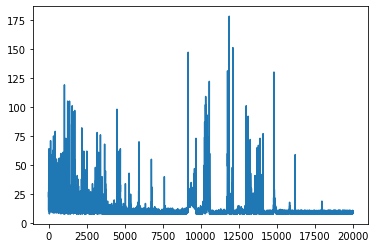

In [405]:
plt.plot(y, x)

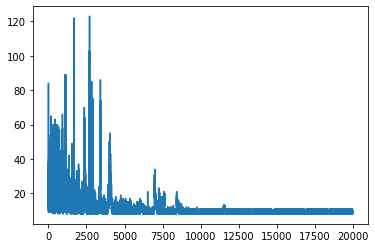

In [401]:
plt.plot(y, x)
#plt.show()

In [226]:
#ntwrk <class 'numpy.int64'>

In [390]:
exp = []
for t, i in enumerate(range(10)):
    v = (t,i)
    exp.append(v)

In [392]:
s, a = exp

ValueError: too many values to unpack (expected 2)

In [57]:
s = [s for s, a  in exp]

ValueError: not enough values to unpack (expected 3, got 2)

In [40]:
s = []
for k, v in exp:
    s.append(v)

In [41]:
type(s)

list

In [54]:
s

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [101]:
type(1)

int

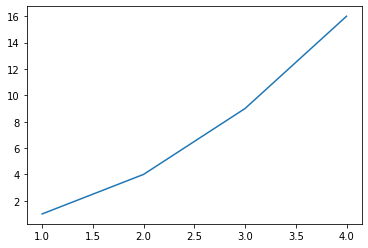

In [242]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])